In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.bezier as bezier
from scipy.special import comb

In [50]:
class Vector:
    def __init__(self, x, y, ray_profile, angle) -> None:
        self.spatial_x = x
        self.spatial_y = y
        self.magnitude = ray_profile
        self.direction = angle

In [51]:
def rotate(x, y, angle):
    new_x = x * np.cos(angle) - y * np.sin(angle)
    new_y = x * np.sin(angle) + y * np.cos(angle)
    return np.array([new_x, new_y])

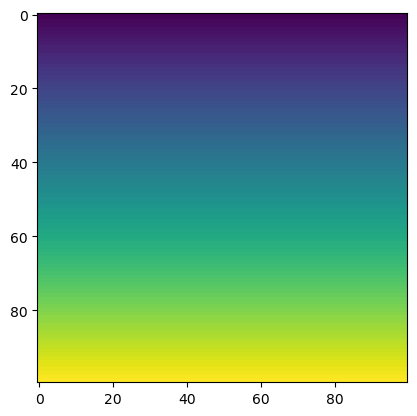

In [52]:
space_size, node_size = 5e-4, 100
x_space_min, x_space_max, y_space_min, y_space_max = -space_size, space_size, -space_size, space_size
x_node_min, x_node_max, y_node_min, y_node_max = 0, node_size, 0, node_size
xx, yy = np.meshgrid(range(x_node_min, x_node_max), range(y_node_min, y_node_max))
z = yy
plt.imshow(z)

In [53]:
def space_to_node(space_x,space_y, z_image):
    node_x = x_node_min + np.floor(x_node_max * (space_x - x_space_min) / (x_space_max - x_space_min))
    node_y = y_node_min + np.floor(y_node_max * (space_y - y_space_min) / (y_space_max - y_space_min))
    return np.array([node_x, node_y])

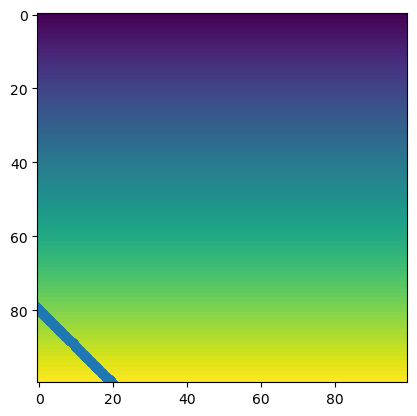

In [74]:
beam_directions = [0, np.pi/4]
beam_positions = [[0,50]]
sp =  np.array([np.zeros(2000), np.linspace(-2e-4,2e-4,2000)])
sp = sp.T
newsp = sp 
direction = -np.pi/4
rotated = rotate(*newsp.T, direction).T + [-4e-4,4e-4]
node_positions = space_to_node(*rotated.T)
# beam = np.vstack((node_positions, full_beam_profile, np.full(2000,direction)))
# beam = pd.DataFrame(beam.T)
# beam = beam.astype({0:'int32',1:'int32'})
# new_beam = beam.groupby([0,1]).sum()
# new_beam.index[]
plt.scatter(*node_positions)
plt.imshow(z)

[None, None]


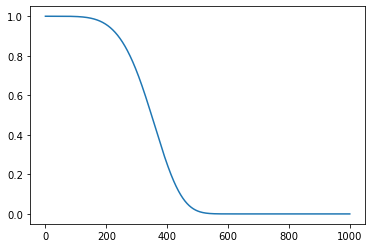

In [194]:
laser_start_points = [(0,50), (50,100)]
beam_normal_directions = [0,np.pi/2] # radians wrt x axis
ray_count_per_beam = 1000

scale_factor = 1
beam_profile_range = np.linspace(0,0.1,ray_count_per_beam) # phase_r
beam_profile = scale_factor * np.exp(-((beam_profile_range/.0375)**2)**(5/2)) # pow_r
half_beam_profile = np.min(beam_profile) + beam_profile

beam_norm = [
    [-1,0,0],
    [0,-1,0]
]
dbeam_norm = [[].append(x) for x in beam_norm]
print(dbeam_norm)


plt.plot(half_beam_profile)


# Bezier estimations

Control Points:  11 Difference:  0.49741853832040045


(array([[-3.14159265e+00,  2.48080441e-03],
        [-2.51327412e+00, -3.68708063e-02],
        [-1.88495559e+00,  1.13195028e+00],
        [-1.25663706e+00,  1.51224740e+00],
        [-6.28318531e-01,  6.35751710e+00],
        [-9.23705556e-14, -1.24346776e+01],
        [ 6.28318531e-01,  6.35751710e+00],
        [ 1.25663706e+00,  1.51224740e+00],
        [ 1.88495559e+00,  1.13195028e+00],
        [ 2.51327412e+00, -3.68708063e-02],
        [ 3.14159265e+00,  2.48080441e-03]]),
 <matplotlib.bezier.BezierSegment at 0x2015cec8400>)

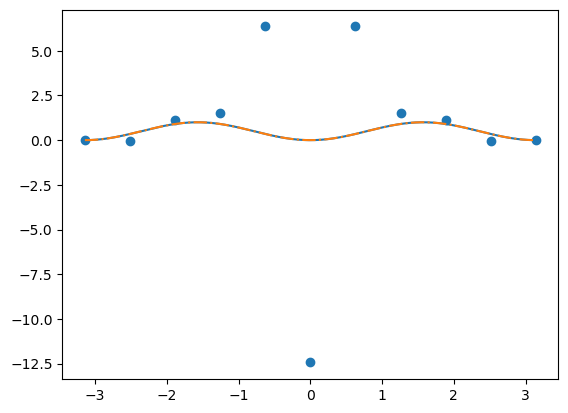

In [92]:
def raster_rays_to_bezier(raster_points, number_of_control_points = 6, plot = False, tolerance = 5, limit_control_points = 100):
    """
    raster_points: np.array[n, 2] ; n is the number of pixels rastered
    number_of_control_points: starting expected number of control points
    tolerance: difference between raster and bezier
    limit_control_points: max number of control points
    """
    x, y = raster_points.T
    if plot:
        plt.plot(x,y)

    # https://stackoverflow.com/questions/12643079/b%C3%A9zier-curve-fitting-with-scipy
    # solves an arbitrary curve for a bezier using all points. produces a bezier curve with number_of_control_points

    matrix = lambda n, t, k: t ** (k) * (1-t) ** (n-k) * comb(n, k) # n: polynomial degree, t: parameter, k: current term
    get_bezier = lambda parameter_range, num_control_points: np.array([[
        matrix(num_control_points-1, t, k) for k in range(num_control_points)] for t in parameter_range
        ])

    def least_squares_fit(points, matrix):
        matrix_ = np.linalg.pinv(matrix)
        return np.matmul(matrix_,points)

    points = np.array(list(zip(x, y)))
    while True:
        control_points = least_squares_fit(points, get_bezier(np.linspace(0,1,1000),number_of_control_points))
        bezier_curve = bezier.BezierSegment(control_points)
        bezier_plot_points = np.array(bezier_curve.point_at_t(np.linspace(0,1,1000)))
        if(np.sum(np.abs(bezier_plot_points - points)) < tolerance or number_of_control_points >= limit_control_points):
            break
        number_of_control_points += 1
    print("Control Points: ", number_of_control_points, "Difference: ", np.sum(np.abs(bezier_plot_points - points)))
    if plot:
        plt.scatter(*control_points.T)
    if plot:
        plt.plot(*bezier_plot_points.T, linestyle='-.')
    return control_points, bezier_curve

x = np.linspace(-np.pi, np.pi, 1000)
y = np.sin(x) ** 2
raster_rays_to_bezier(np.array([x,y]).T, 1, plot =True)